In [ ]:
# Example of a GAN
# Given that it uses convolutional layers, it is actually a Deep Convolutional GAN (DCGAN)

In [ ]:
# https://jonathan-hui.medium.com/gan-a-comprehensive-review-into-the-gangsters-of-gans-part-1-95ff52455672
# https://lilianweng.github.io/lil-log/2017/08/20/from-GAN-to-WGAN.html
# https://machinelearningmastery.com/how-to-implement-wasserstein-loss-for-generative-adversarial-networks/

# https://www.tensorflow.org/tutorials/generative/dcgan
# https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/

# https://machinelearningmastery.com/how-to-train-a-progressive-growing-gan-in-keras-for-synthesizing-faces/
# https://machinelearningmastery.com/how-to-develop-a-pix2pix-gan-for-image-to-image-translation/

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Dropout
from tensorflow.keras.layers import Reshape, Flatten, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [ ]:
# Constants
NROWS = 28
NCOLS = 28
NCHAN = 1

z_dim = 128

# Discriminator

In [ ]:
def create_discriminator(NROWS, NCOLS, NCHAN):
  model = Sequential()
  model.add(Input(shape=(NROWS, NCOLS, NCHAN)))
  
  model.add(Conv2D(128, 3, strides=2, padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(128, 3, strides=2, padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  #model.add(Conv2D(32, 3, strides=2, padding='same'))
  #model.add(LeakyReLU(alpha=0.2))

  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])
  return model

Number of parameters: 155,137


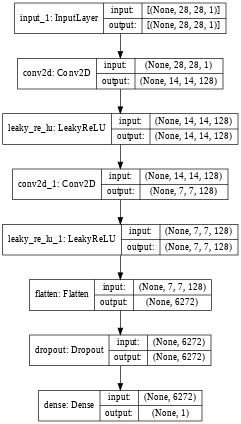

In [ ]:
disc = create_discriminator(NROWS, NCOLS, NCHAN)
print(f"Number of parameters: {disc.count_params():,}")
plot_model(disc, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=48)

# Generator

In [ ]:
def create_generator(z_dim):
  model = Sequential()
  model.add(Input(shape=(z_dim,)))

  model.add(Dense(7 * 7 * 128))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((7, 7, 128)))

  model.add(Conv2DTranspose(128, 4, strides=2, padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2DTranspose(128, 4, strides=2, padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  #model.add(Conv2D(128, 3))
  #model.add(LeakyReLU(alpha=0.2))

  #model.add(Conv2DTranspose(128, 4, strides=2, padding='same'))
  #model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(1, 7, padding='same', activation='tanh'))

  return model

Number of parameters: 1,339,905


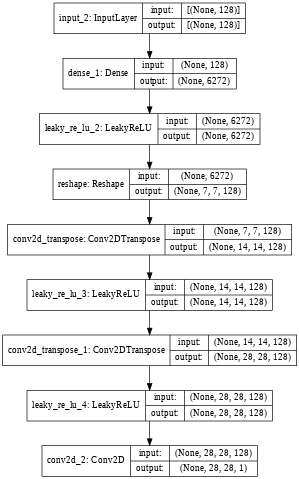

In [ ]:
gene = create_generator(z_dim)
print(f"Number of parameters: {gene.count_params():,}")
plot_model(gene, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=48)

In [ ]:
# Delete them just to show we can recreate them later on
del disc, gene

# Full GAN

In [ ]:
def create_gan(generator, discriminator):
  discriminator.trainable = False

  gen_noise = generator.input #(None, 128)
  gen_output = generator.output #(None, 28, 28, 1)
  
  gan_output = discriminator(gen_output)
  
  model = Model(gen_noise, gan_output)
  model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
  
  return model

Number of parameters: 1,495,042


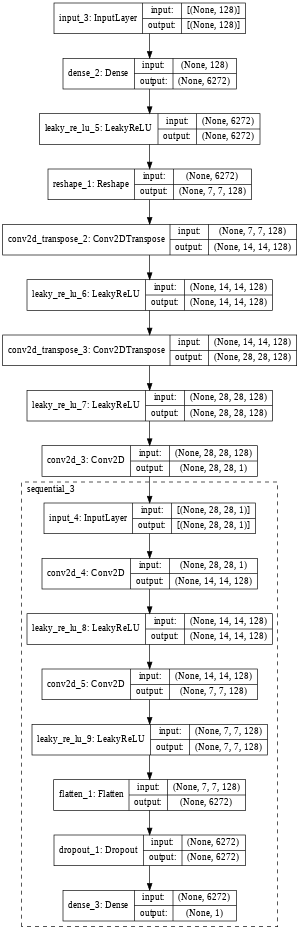

In [ ]:
gene = create_generator(z_dim)
disc = create_discriminator(NROWS, NCOLS, NCHAN)
GAN  = create_gan(gene, disc)
print(f"Number of parameters: {GAN.count_params():,}")
plot_model(GAN, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=48)

In [ ]:
def train(X, params):
  """
  X: ejemplos de datos reales
  params: set de hyperparametros
  """

  # Unzip hyper-parameters
  n_epochs = params['n_epochs']
  batch_size = params['batch_size']
  z_dim = params['z_dim']
  sample_interval = params['sample_interval'] # para imprimir info

  # Performance storage
  accuracies = []
  losses = []

  # Labels for real and fake images
  real = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for epoch in range(n_epochs):
    # -- Train Discriminator
    # Get a random batch of real images
    idx = np.random.randint(0, X.shape[0], batch_size)
    imgs = X[idx]

    # Generate a batch of fake images (lote de vectores random)
    z = np.random.normal(0, 1, (batch_size, z_dim))
    gen_imgs = gene.predict(z)
    
    # Training
    d_loss_real = disc.train_on_batch(imgs, real)
    d_loss_fake = disc.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # -- Train Generator
    # Generate a batch of noise vectors and get a batch of random labels
    z = np.random.normal(0, 1, (batch_size, z_dim))

    # Training
    g_loss = GAN.train_on_batch(z, real)

    if (epoch % sample_interval) == 0:
      print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))

      # Save losses and accuracies so they can be plotted after training
      losses.append((d_loss[0], g_loss))
      accuracies.append(100 * d_loss[1])

      # Output sample of generated images
      sample_images(z_dim)

  return losses, accuracies

In [ ]:
def sample_images(z_dim):
  z = np.random.normal(0, 1, (2 * 5, z_dim))
  labels = np.arange(0, 10).reshape(-1, 1)

  # Generate images from random noise
  gen_imgs = gene.predict(z)
  gen_imgs = 0.5 * gen_imgs + 0.5

  ind = 0
  fig, axs = plt.subplots(2, 5, figsize=(10, 4), sharey=True, sharex=True)
  for i in range(2):
    for j in range(5):
      axs[i, j].imshow(gen_imgs[ind, :, :, 0], cmap='gray')
      axs[i, j].axis('off')
      ind += 1
  plt.show()

In [ ]:
# Load data
(x_train, _), (_, _) = mnist.load_data()

# Rescale [0, 255] grayscale pixel values to [-1, 1]
x_train = x_train / 127.5 - 1.
x_train = np.expand_dims(x_train, axis=3)

# Turn into float32
x_train = x_train.astype('float32')

print(x_train.shape)

(60000, 28, 28, 1)


0 [D loss: 0.747039, acc.: 6.25%] [G loss: 0.692373]


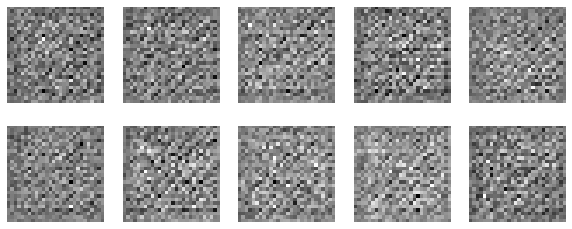

1000 [D loss: 0.000054, acc.: 100.00%] [G loss: 9.311757]


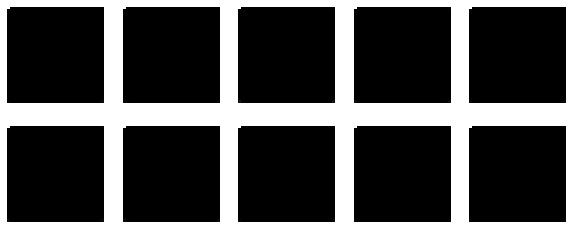

2000 [D loss: 0.759840, acc.: 48.83%] [G loss: 0.720783]


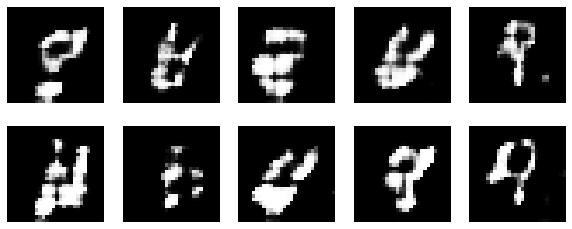

3000 [D loss: 0.726673, acc.: 44.14%] [G loss: 0.732649]


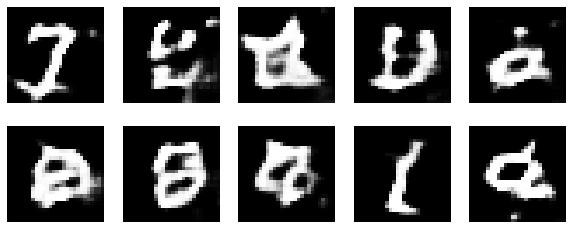

4000 [D loss: 0.679478, acc.: 58.20%] [G loss: 0.747242]


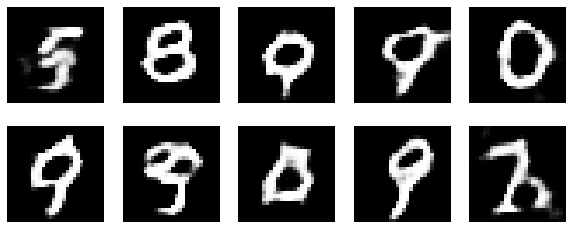

5000 [D loss: 0.672492, acc.: 60.16%] [G loss: 0.818739]


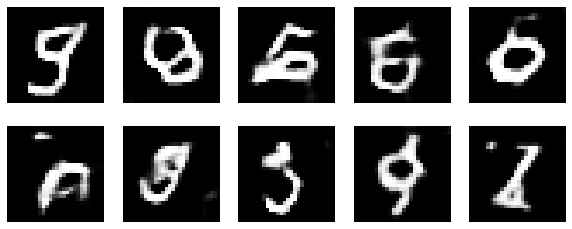

6000 [D loss: 0.686784, acc.: 57.81%] [G loss: 0.722131]


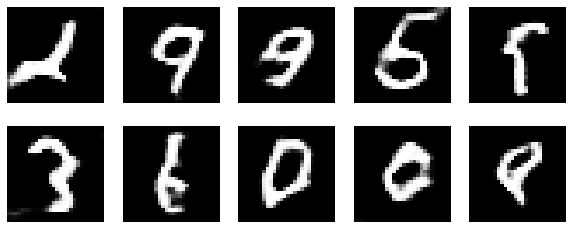

7000 [D loss: 0.733216, acc.: 43.36%] [G loss: 0.675816]


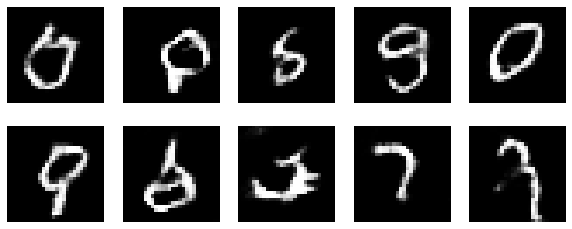

8000 [D loss: 0.675527, acc.: 60.16%] [G loss: 0.825622]


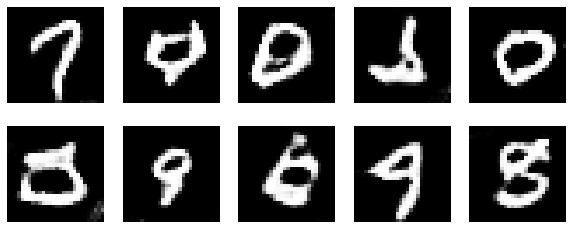

9000 [D loss: 0.688011, acc.: 55.47%] [G loss: 0.738718]


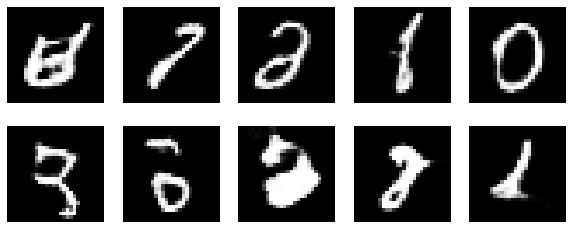

10000 [D loss: 0.696731, acc.: 50.39%] [G loss: 0.753358]


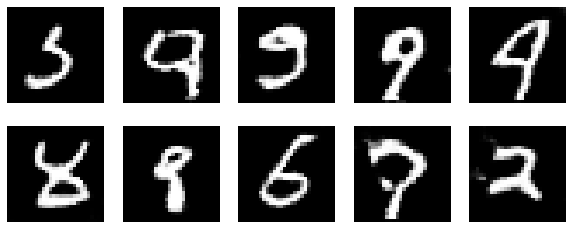

11000 [D loss: 0.679066, acc.: 59.38%] [G loss: 0.724188]


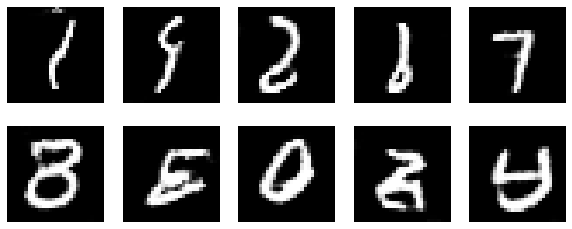

12000 [D loss: 0.689369, acc.: 52.34%] [G loss: 0.730472]


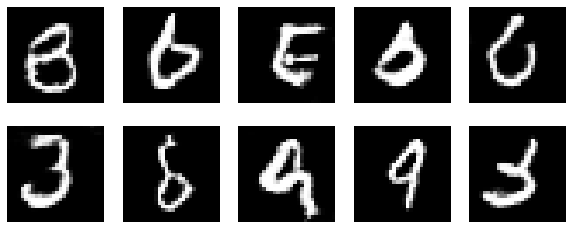

13000 [D loss: 0.697048, acc.: 51.17%] [G loss: 0.717506]


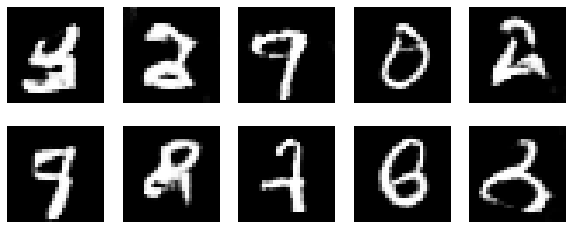

14000 [D loss: 0.691783, acc.: 53.91%] [G loss: 0.710888]


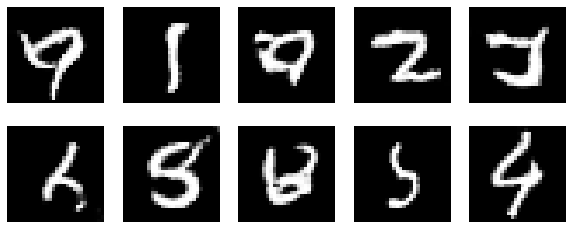

15000 [D loss: 0.695728, acc.: 51.56%] [G loss: 0.733963]


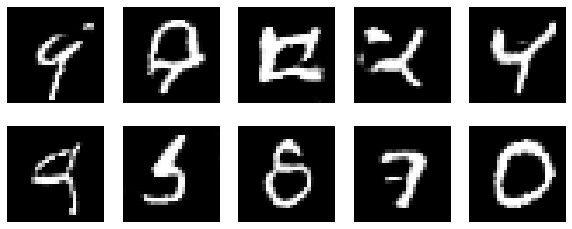

16000 [D loss: 0.690992, acc.: 53.91%] [G loss: 0.705559]


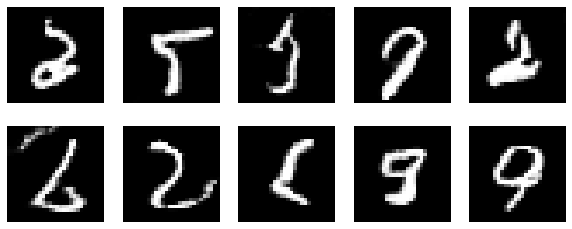

17000 [D loss: 0.692641, acc.: 48.05%] [G loss: 0.717780]


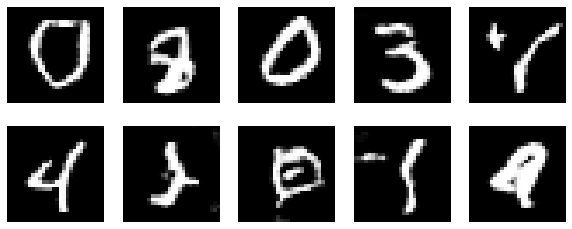

18000 [D loss: 0.690402, acc.: 57.42%] [G loss: 0.720891]


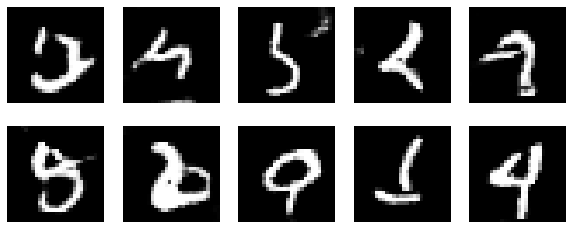

19000 [D loss: 0.695688, acc.: 51.56%] [G loss: 0.706324]


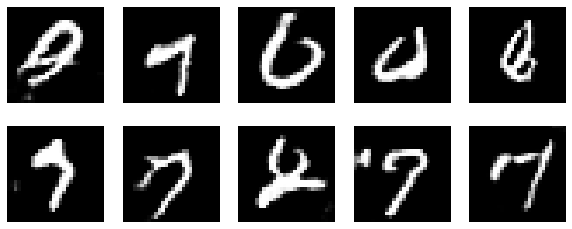

In [ ]:
# Set some hyperparameters
params = {
    'n_epochs': 20000,
    'batch_size': 128,
    'sample_interval': 1000,
    'z_dim': z_dim,
}

# Train the CGAN for the specified number of iterations
losses, accuracies = train(x_train, params)

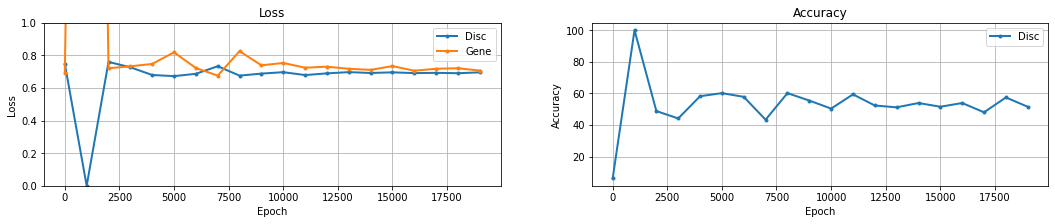

In [ ]:
# Plot loss
losses = np.array(losses)
accuracies = np.array(accuracies)

plt.figure(figsize=(18, 3))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(range(1, params['n_epochs'], params['sample_interval']), losses[:, 0], label='Disc', marker='.', linewidth=2)
plt.plot(range(1, params['n_epochs'], params['sample_interval']), losses[:, 1], label='Gene', marker='.', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim((0, 1))
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(range(1, params['n_epochs']+1, params['sample_interval']), accuracies, label='Disc', marker='.', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()